In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchsummary import summary
import torch.optim as optim
#----------------------------------
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

device = "cuda" if torch.cuda.is_available else "cpu"

In [3]:
Lenet = LeNet().to(device)

In [4]:
#load the model

model_path = os.getcwd() +"/lenet_MNIST.pth"
print(model_path)
Lenet = torch.load(model_path, map_location=torch.device('cuda'))


/home/ag8298/Desktop/Summer2023/lenet/lenet_MNIST.pth


In [5]:
summary(Lenet, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]           5,020
         Dropout2d-3             [-1, 20, 8, 8]               0
            Linear-4                   [-1, 50]          16,050
            Linear-5                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.08
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


In [6]:
data_test = datasets.MNIST('./data',
        download=True,train=False,transform=ToTensor())

test_loader = DataLoader(data_test)

/usr/lib/python3/dist-packages/torch/nn/functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


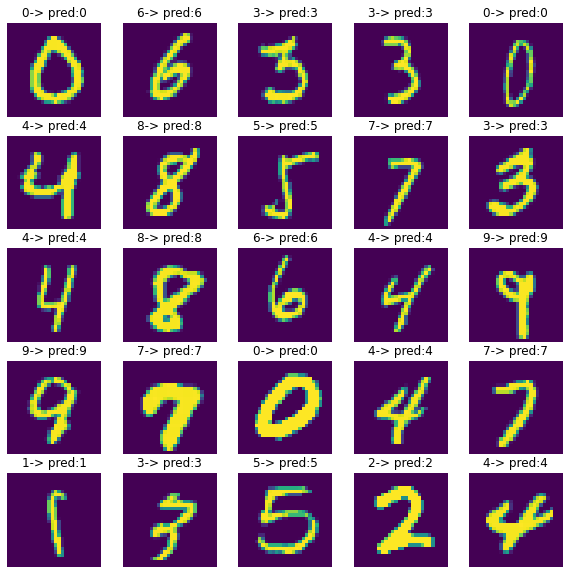

In [7]:
figure = plt.figure(figsize = (10,10))
cols, rows = 5,5
for i in range(1, cols*rows + 1):
    index = torch.randint(len(data_test), size = (1,)).item()
    figure.add_subplot(rows, cols, i)
    img = data_test[index][0]
    label = data_test[index][1]
    #------------------------------
    features = img
    features = features.to(device)
    out = Lenet(features)
    pred = torch.max(out,1)[1]
    #-----------------------------
    plt.title(f"{label}-> pred:{pred.item()}")
    plt.axis("off")
    plt.imshow(img.view(28,28))

    #plt.imshow(img.numpy().squeeze(),cmap="Greys")           # .squeeze() flattens the given tensor or matrix into 1-d array.
plt.show()

### Carlini and Wagner attack. 

In [8]:
#carlini and wagner attack
#inputs - 

In [24]:
print(label.shape)

torch.Size([1])


In [53]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.optim as optim

def carlini_wagner_attack(model, original_image, target_class, num_iterations=10, lr=0.01, confidence=0.0):
    # Set the model in evaluation mode
    model.eval()
    
    # Convert the original image to a tensor and keep it as a variable to track gradients
    original_image = Variable(original_image, requires_grad=True)
    
    # Define the attack objective
    target = torch.tensor(target_class)
    targeted_loss = nn.CrossEntropyLoss()
    
    # Define the optimizer
    optimizer = optim.Adam([original_image], lr=lr)
    
    # Perform the optimization iterations
    for _ in range(num_iterations):
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass to obtain the logits
        logits = model(original_image)
        
        # Calculate the loss
        loss = targeted_loss(logits, target)
        
        # Calculate the gradients
        loss.backward()
        
        # Update the original image using the gradients
        optimizer.step()
        
        # Project the perturbations to the L-infinity ball with the desired confidence
        perturbations = torch.clamp(original_image.data - original_image, -0.1, 0.1)
        original_image.data = torch.clamp(original_image.data + perturbations, 0, 1)
    
    # Return the adversarial example
    return original_image.data



In [54]:
adv_examples = []
count = 1
for image, label in test_loader:
    image, label = image.to(device), label.to(device)
    adv = carlini_wagner_attack(Lenet, image, (label + 1) % 10)
    adv_examples.append((adv,label))
    

/tmp/ipykernel_3099359/520719262.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target_class)


In [46]:
len(adv_examples)

10000

In [47]:
adv_examples[0][0].shape

torch.Size([1, 1, 28, 28])

tensor([0], device='cuda:0')


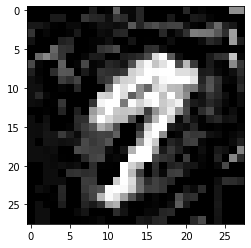

In [48]:
img = adv_examples[20][0].squeeze(0).squeeze(0).to("cpu").detach().numpy()
plt.imshow(img, cmap="gray")

out = Lenet(adv_examples[20][0])
pred = torch.max(out,1)[1]
print(pred)


In [49]:
#test the accuracy of the model.
count = 1
correct = 0
for each in adv_examples:
    image = each[0]
    label = each[1].item()
    #----------
    out = Lenet(image)
    pred = torch.max(out, 1)[1].item()
    #print("the original label was ", label," while the prediction is ",pred)
    if label == pred:
        correct += 1
    

print(f"correct : {correct} and accuracy : {(correct/float(len(adv_examples)))*100} %")

correct : 3 and accuracy : 0.03 %


### Torch attack library implementation of Carlini and Wagner attack

In [50]:
#Torch attack implementation of Carlini and Wagner attack.
import torchattacks.attacks

carlini_torch = []
attack = torchattacks.CW(Lenet)
for image, label in test_loader:
    image, label = image.to(device), label.to(device)
    adv = attack(image, label)
    carlini_torch.append((adv,label))
    
    
    

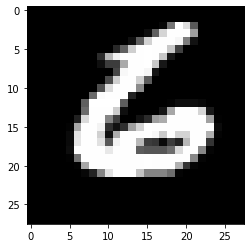

In [51]:
#visualizing the last dataset in the dataloader.
img = adv.squeeze(0).squeeze(0).to("cpu").detach().numpy()

plt.imshow(img, cmap="gray")

In [52]:
#calculate the accuracy of the torchlibrary attack
correct = 0

for each in carlini_torch:
    image = each[0]
    label = each[1]
    out = Lenet(adv)
    pred = torch.max(out, 1)[1]
    if label.item() == pred.item():
        correct += 1
    
print(f"Correct predictions: {correct} , Accuracy: {(correct/float(len(carlini_torch)))*100} % ")


Correct predictions: 958 , Accuracy: 9.58 % 
